# Emotion in speech

The next dataset contains short speech audio clips in German. 45 files in total.

Each audio clip has two associated values between -1 and 1, one for _arousal_ and one for _valence_, in the corresponding CSV files.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob, os, pickle
from IPython.display import Audio
import scipy.io.wavfile
from ipywidgets import interact
from IPython.display import Audio
import pandas as pd
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)

In [3]:
import librosa # https://github.com/librosa/librosa
import keras

## Data

Download the data from [GitHub](https://github.com/yoavram/SpeechEmotion/archive/master.zip) (data originally from user Theodoros Giannakopoulos' [pyAudioAnalysis repo](https://github.com/tyiannak/pyAudioAnalysis)).
Extract the zip file into the `data` folder.
Now the files are in `data/SpeechEmotion-master/data`.

This cell reads the `csv` files.

In [4]:
valence = pd.read_csv('../data/SpeechEmotion-master/data/valence.csv', header=None).iloc[:,1].values
arousal = pd.read_csv('../data/SpeechEmotion-master/data/arousal.csv', header=None).iloc[:,1].values

The next functions are similar to the ESC-50 session, loading, plotting and plying an audio clip.

In [5]:
audio_fname_template = '../data/SpeechEmotion-master/data/{:02d}.wav'

def load_wave(i):
    fname = audio_fname_template.format(i)
    rate, wave = scipy.io.wavfile.read(fname)
    wave = (wave + 0.5) / (0x7FFF + 0.5)  # convert to float
    wave *= 1.0 / np.max(np.abs(wave)) # normalize
    return wave, rate
wave, rate = load_wave(0)

Arousal: 0.25
Valence: -0.7


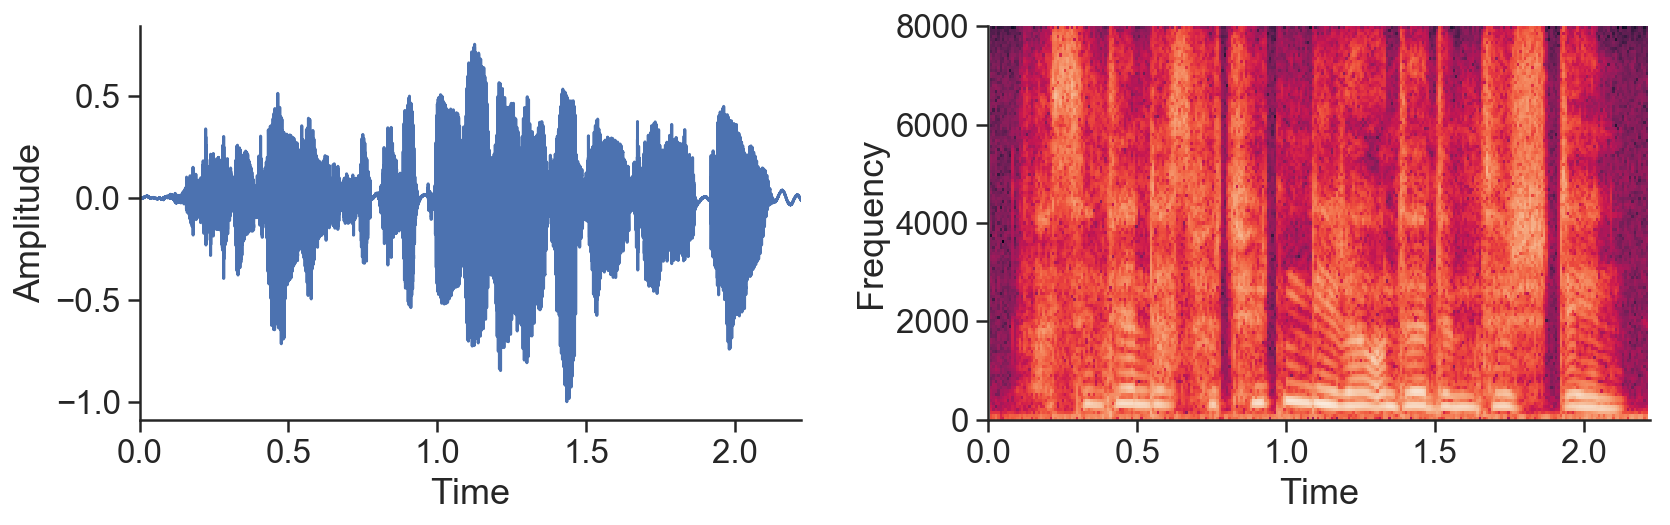

In [6]:
@interact(i=(0, 44))
def play_speech(i):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    wave, rate = load_wave(i)
    axes[0].plot(np.arange(0, wave.size/rate, 1/rate), wave)
    axes[0].set(xlim=(0, wave.size/rate), xlabel='Time', ylabel='Amplitude')
    f, t, spectrogram, im = axes[1].specgram(wave, Fs=rate)
    axes[1].set(xlim=(0, wave.size/rate), xlabel='Time', ylabel='Frequency')
    sns.despine()
    fig.tight_layout()
    print('Arousal:', arousal[i])
    print('Valence:', valence[i])
    return Audio(wave, rate=rate)

Let's also look at the distribution of arousal and valence values (on the main diagonal) and their joint distributions (on the off-diagonal).

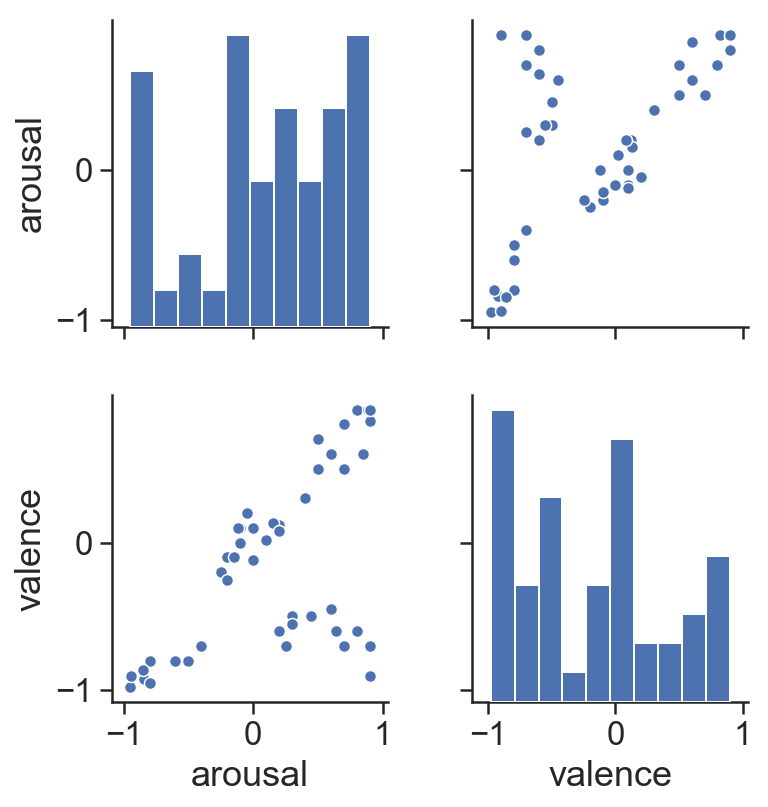

In [7]:
sns.pairplot(pd.DataFrame({'arousal':arousal, 'valence': valence}), height=3, plot_kws=dict(marker='o'));

# Model building and training

We want to train a neural network to predict arousal and valence in speech.
You can reuse code from the [ESC-50 sounds classification example](../audio.ipynb).

Notes:
- here we are doing regression of two dependent variables (arousal and valence) rather than classification of a single variable.
- the sampling rate of the speech files is 16,000 Hz rather than 44,200.
- the audio clips are of variable length; you can solve this by segmenting them to identical lengths, but the code needs to be a bit different than the one we used for ESC-50, as you will get a different number of segments from each clip.
- if you choose to generate the _delta_ feature, you should consider changing the window width.
- there are only 45 files, so consider reducing the size of the network either by removing layers or decreasing the size of the kernels.

In [15]:
def load_spectogram(i):    
    wave, rate = load_wave(i)
    spec = librosa.feature.melspectrogram(wave, sr=rate, n_fft=1024,
                                          hop_length=512, n_mels=60)
    spec = librosa.amplitude_to_db(spec)    
    return spec

def segement_spectogram(spec, segment_length=20, step=10):
    offset = 0
    segments = []
    while offset < spec.shape[1] - segment_length:
        segment = spec[:, offset:offset+segment_length]
        offset += step
        segments.append(segment)
    return segments

Start by segmenting the clips and adding the delta feature as a second channel:

In [16]:
X = []
Yar = [] 
Yva = [] 
for i in range(45):
    segments = segement_spectogram(load_spectogram(i))
    Yar.extend([arousal[i]] * len(segments))
    Yva.extend([valence[i]] * len(segments))
    X.extend(segments)
X = np.array(X)
Yar = np.array(Yar)
Yva = np.array(Yva)

In [17]:
deltas = [librosa.feature.delta(seg, width=5) for seg in X]
X = np.stack((X, deltas), axis=-1)

Stack both Y values togheter:

In [18]:
Y = np.stack((Yar, Yva), axis=-1)

**Create a neural network** with two convolutional layers (with relu and max pooling) and two dense layers, where the second one is the readout layer (hence there is no activation on the final layer; should we have addes an activation due to the range of (-1,1) on y values?).

We use the mean squared error as a loss function; other alternatives may be more appropriate if we add an activation function to the readout layer, or even if we don't, again due to the support of the targets on (-1,1).

Fit the model.

In [21]:
model.save('../data/keras_emotion_model.h5')
with open("../data/keras_emotion_history.p", "wb") as f:
    pickle.dump(history, f)

Load model and history:

In [22]:
model = keras.models.load_model('../data/keras_emotion_model.h5')
with open("../data/keras_emotion_history.p", "rb") as f:
    history= pickle.load(f)

Plot the history of the MSE:

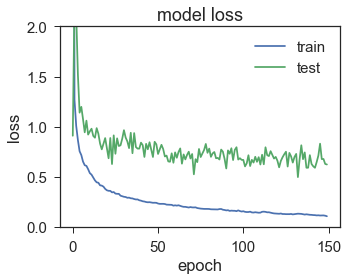

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharex=True)

ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch',
    ylim=(0, 2)
)
ax.legend()
    
fig.tight_layout()

Predict and compare to truth:

In [24]:
Yhat = np.squeeze(np.array([model.predict(x.reshape(1, *x.shape)) for x in X]))

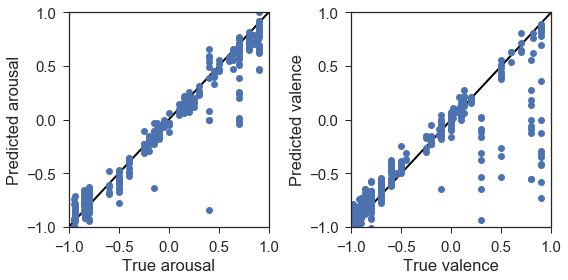

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.linspace(-1, 1), np.linspace(-1, 1), lw=2, color='k')
ax.plot(Yar, Yhat[:,0], 'o')
ax.set(xlabel=('True arousal'), ylabel=('Predicted arousal'), xlim=(-1, 1), ylim=(-1, 1))

ax = axes[1]
ax.plot(np.linspace(-1, 1), np.linspace(-1, 1), lw=2, color='k')
ax.plot(Yva, Yhat[:,1], 'o')
ax.set(xlabel=('True valence'), ylabel=('Predicted valence'), xlim=(-1, 1), ylim=(-1, 1))

fig.tight_layout()

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)